## Text Pre-processing

Preprocessing for NLP is a very task dependent process. The steps we take are dependent on the aims and methods we intend to apply at the modelling stage, as such there may be different paths to take.

As a reminder, the task of our study is to be able to train models that are able to effectively classify text comments as Toxic, while minimising bias. Key to doing this will be to train a model that is able to understand contextual relationships between words, but also perhaps to understand the contextual impact of punctuation at a certain point. To help understand this, consider the impact of exclamation points to your view of the context of a sentence. 

Standard NLP preprocess workflows would generally remove punctuation given that classic methods of word-embedding such as TF-IDF do not gain meaning from these outside of their counts. However the use of pre-trained word-embeddings such as fasttext, GloVE, word2vec, and others, often contain vector representations of punctuation that has been learned by studying their relationships to other words. As a result, we could now skip the removal of punctuation.

### Our Method:

For this project we are following two paths. 

#### Traditional ML
We will be training a series of classic ML classifiers such as SVM, Logistic Regression and Random Forest. We will embed the words using TF-IDF and therefore we will use a traditional NLP workflow.

 1. Remove punctuation, convert to lower case
 2. Tokenization
 3. Removal of stop words
 4. Stemming/Lemmatization
 
We will use tools from NLTK/Spacy to achieve this, with adjustments for quirks in our data. 

#### Neural Networks with GloVe
We will also be training a neural network model which takes advantage of glove word embeddings. As such we will not be carrying out the standard work flow. Instead, we will begin by comparing the number of tokens in our dataset vocabulary to the glove word embeddings. We will remove as many OOV words/symbols as we can. 

We will then attempt to correct issues such as misspellings that are causing words to not match with the word-embeddings. We will leave in punctuation that has a vector representation.




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import contractions
import tqdm
from tqdm import tqdm
tqdm.pandas()
import gc
import operator

/Users/gov/anaconda3/envs/capstone/lib/python3.7/site-packages/tqdm/std.py:651: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
# Load in the cleaned train and cleaned+concatenated test datasets. 
train_df = pd.read_csv('data/train_clean.csv')
test_df = pd.read_csv('data/test_clean.csv')

In [3]:
# Filter out the first 
train_df = train_df.iloc[:,1:]
test_df = test_df.iloc[:,1:]

### Cleaning for ML classifiers

We need to explore the text to get a better idea of what we need to do.

In [6]:
# Character count - pre any pre-processing
len_list = []
for i in train_df['comment_text']:
    len_list.append(len(i))

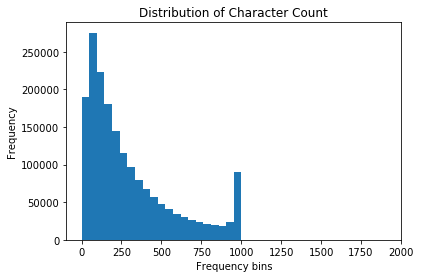

In [7]:
#plot histogram
plt.figure()
plt.hist(len_list, bins=40)
plt.xlabel('Frequency bins')
plt.ylabel('Frequency')
plt.title('Distribution of Character Count')
plt.show()

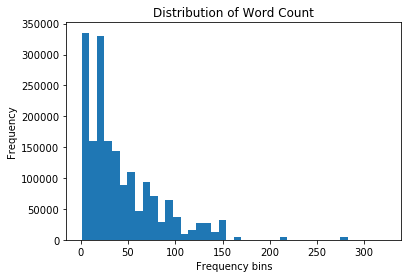

In [8]:
# Now lets look at the number of WORDS in each comment
words = train_df['comment_text'].apply(lambda x: len(x) - len(''.join(x.split())) + 1)
train_df['words'] = words
words = train_df.loc[train_df['words']]['words']
plt.figure()
plt.hist(words, bins=40)
plt.xlabel('Frequency bins')
plt.ylabel('Frequency')
plt.title('Distribution of Word Count')
plt.show()

In terms of characters, we see a somewhat bimodal distribution, with the majority of comments being very short, but another peak appearing around the 1000 charachter length. This may suggest that certain publications had a default max charachter limit set at 1000.

In terms of actual word count, we see a more standard positive skew to the data.

This is useful information to know given that we will likely need to restrict the length of our sequences before feeding them into models to account for memory constraints. 

In [9]:
#summary statistics for characters
len_list = np.asarray(len_list)
mean = len_list.mean()
median = np.median(len_list)
upper_quart = np.percentile(len_list, 75)
lower_quart = np.percentile(len_list, 25)
min_val = len_list.min()
max_val = len_list.max()
print(f' min: {min_val} \
         25%: {lower_quart} \
         50%: {median} \
         75%: {upper_quart} \
         max: {max_val} \
         mean: {mean}'
     )

 min: 1          25%: 94.0          50%: 202.0          75%: 414.0          max: 1906          mean: 297.2343266067327


In [4]:
# find comments with max length = 1000
df = train_df
# create new column with comment length
df['comment_len'] = len_list

In [11]:
# boolean index for comments of 1000
df[df['comment_len'] == 1000]

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,target_class,words,comment_len
516,240627,0,"BJ, your suggestion that low income residents ...",0.0,0.0,0.0,0.0,0.0,0,0,...,0,0,0,0,0.0,4,4,0,185,1000
529,240648,0,Resolution 08-3945 presented to Metro council ...,0.0,0.0,0.0,0.0,0.0,0,0,...,0,0,1,0,0.0,0,4,0,175,1000
606,240802,0,"Quoting Joni Mitchell, ""Don't it always seem t...",0.0,0.0,0.0,0.0,0.0,0,0,...,0,0,0,0,0.0,0,4,0,155,1000
820,241094,0,Is it not in the best interest of the OLCC to ...,0.0,0.0,0.0,0.0,0.0,0,0,...,0,0,0,0,0.0,0,4,0,192,1000
834,241112,0,While I can't speak to the factual accuracy in...,0.0,0.0,0.0,0.0,0.0,0,0,...,0,0,4,0,0.0,0,4,0,175,1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1803524,6331991,0,"As I've said before, Island Air was operating ...",0.0,0.0,0.0,0.0,0.0,0,0,...,0,0,0,0,0.0,0,4,0,176,1000
1803810,6332378,0,"Oh I read it!\n\n\nAnd again, teach Latin and ...",0.0,0.0,0.0,0.0,0.0,0,0,...,0,0,1,0,0.0,0,4,0,171,1000
1804543,6333400,0,This idea that an old universe is at odds with...,0.0,0.0,0.1,0.1,0.0,0,0,...,0,0,0,0,0.0,0,10,0,182,1000
1804766,6333742,0,Paul: The whole topic of graduation rates is ...,0.0,0.0,0.0,0.0,0.0,0,0,...,0,0,0,0,0.0,0,4,0,160,1000


In [12]:
# select the publication_id column and get value counts
df[df['comment_len'] == 1000].loc[:,'publication_id'].value_counts().head(15)

21     2675
54     2650
13     1334
53     1173
102     810
22      758
55      494
100     188
105     149
66      101
43      100
6        64
93       33
73       32
87       28
Name: publication_id, dtype: int64

In [13]:
# check total counts for publication id 
train_df['publication_id'].value_counts().head(15)

54     627278
21     377686
102    213846
13     156682
55     133464
53     129243
22      54767
105     38934
100     23441
43      10952
6       10824
66       8095
93       3597
52       2323
87       1692
Name: publication_id, dtype: int64

Given the total number of rows for the publication ids with the highest occurance of 1000 length comments, we can't say there appears to be a trend here. We may just have some form of default max length. In any case, we will most likely have to set a max length for these comments when training our neural network model due to memory constraints. We should still capture the majority of comments.

------------------------

### Text Pre-processing:

We will start with a baseline approach of:
* Casing to lower
* Expanding contractions
* Tokenizing - Uses nltk.TweetTokenizer (with reduce_len = true)
* Removing Stop words Uses nltk.English stop words
* Lemmatizing - nltk. wordnet lemmatizer on adverbs, adjectives, verbs and nouns

This is a standard workflow for pre-processing text. We will experiment with results if we remove some of these

Ultimately this is a difficult task given these are online comments. We will likely see numerous misspellings that cause the tools we use to miss certain issues. 

In [25]:
# to lower case.
df['cleaned_comment'] = df['comment_text'].apply(lambda x: x.lower())

In [26]:
# use contractions library to expand contractions
# Contraction package code can be found here https://github.com/kootenpv/contractions, contractions list can be found below
# https://github.com/kootenpv/contractions/blob/master/contractions/__init__.py
# The package is very useful for expanding contractions and is good at doing so for slang 

# We could also implement this using a dictionary built from 
# https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions

def contraction_expand(text):
    return contractions.fix(text)
#teststr = "hi i'm the coolest cat yall, y'all, there's isn't"

df['cleaned_comment'] = df['cleaned_comment'].apply(lambda x: contraction_expand(x))

In [27]:
# Quick check of some comments
print(df['comment_text'].loc[1])
print(df['cleaned_comment'].loc[1])
print('')
print(df['comment_text'].loc[204000])
print('')
print(df['cleaned_comment'].loc[204000])

print('')
print(df['comment_text'].loc[565934])
print('')
print(df['cleaned_comment'].loc[565934])

Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way!
thank you!! this would make my life a lot less anxiety-inducing. keep it up, and do not let anyone get in your way!

And what are your qualifications as an expert in world monetary policies?  Not trying to insult you sir but your handle gives no clue of who you are or what are your talents.   I'm certain that Krugman circulates in elite company of many decorated economist- some who certainly challenge his theories, some who are supportive.   

I find him interesting but still worry about what line might represent unsustainable debt.   *I'm strongly against a balanced budget amendment, no private institution would work under that constraint - but it does seem we need some debt limits.   I am no economist, but I'm not ignorant on all financial topics either.   Not a Macro guy at all

Peace

and what are your qualifications as an expert in world monetary policies?  not trying

So far we can see that we have successfuly converted the strings to lower case and appear to have expanded out contractions, certainly we have captured common cases such as "I'm". We will now progress to the next stage.

In [28]:
# TOKENIZATION

# We will use the TweetTokenizer from nltk.
# Our data has been taken from online comments, which likely share very similar traits as a Tweet, such as hashtags and
# additional punctuation for emphasis. This tokenizer should more effectively deal with them.
from nltk.tokenize import TweetTokenizer

tokenizer = TweetTokenizer(reduce_len=True) # Set reducelen to true to somewhat reduce lengths of words like 'waaayyy'

#apply tokenizer using lambda function 
df['cleaned_comment'] = df['cleaned_comment'].apply(lambda x: tokenizer.tokenize(x))

In [29]:
# remove stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# remove stop words via lambda function and list comprehension
df['cleaned_comment'] = df['cleaned_comment'].apply(lambda x: [item for item in x if item not in stop_words])

In [30]:
# Clean Punctuation
# We are taking advantage of the translate functionality of the string function. 

# first we make a translation table - what we are doing here is actually making an empty table. The third argument is for
# charachters which will be mapped to None if found. As such by putting in string.punctuation we are creating a translate
# table which will set punctuation to none 
punc_table = str.maketrans('', '', string.punctuation)
df['cleaned_comment'] = df['cleaned_comment'].apply(lambda x: [item.translate(punc_table) for item in x])


In [31]:
# quick check
print(df.loc[1,['comment_text', 'cleaned_comment']])

comment_text       Thank you!! This would make my life a lot less...
cleaned_comment    [thank, , , would, make, life, lot, less, anxi...
Name: 1, dtype: object


In [32]:
%%time
# lemmatize words using the WordNetLemmatizer
from nltk.stem import WordNetLemmatizer


# Lemmatizer works on part of speech words, so we need to run this over the various pos,
lemmatizer = WordNetLemmatizer()
def lemmatize_text_noun(text):
    return [lemmatizer.lemmatize(w, pos='n') for w in text]

def lemmatize_text_verb(text):
    return [lemmatizer.lemmatize(w, pos='v') for w in text]
def lemmatize_text_adj(text):
    return [lemmatizer.lemmatize(w, pos='a') for w in text]
def lemmatize_text_adv(text):
    return [lemmatizer.lemmatize(w, pos='r') for w in text]

df['cleaned_comment'] = df['cleaned_comment'].apply(lemmatize_text_noun)
df['cleaned_comment'] = df['cleaned_comment'].apply(lemmatize_text_verb)
df['cleaned_comment'] = df['cleaned_comment'].apply(lemmatize_text_adj)
df['cleaned_comment'] = df['cleaned_comment'].apply(lemmatize_text_adv)

CPU times: user 13min 56s, sys: 6min 8s, total: 20min 4s
Wall time: 31min 51s


This is now the end of our standard pipeline, we have put all the above steps together in a function below which we can apply to the text. THis will also allow us to ensure we treat the test set in the exact same way as we have done for the training set.

Before we move on let's see our remaining vocabulary present. 

In [ ]:
from nltk.tokenize.treebank import TreebankWordDetokenizer
detokenizer = TreebankWordDetokenizer()

df['cleaned_untoken'] = df['cleaned_comment'].apply(lambda x: detokenizer.detokenize(x))

In [ ]:
# Define build vocab function
def build_vocab(texts, verbose= True):
    
    """
    Function that will iterate over the dataframe rows and builds a dictionary for the words as well as their count
    Uses the tqdm library to create a progressbar given the size of task
    
    PARAMETERS:
    texts: pandas series with comment to parse
    verbose: Set to false for no progress bar
    
    RETURNS
    vocab: Dictionary of words and their counts
    """
    vocab = {}
    for i in tqdm(range(len(texts)), disable = (not verbose)):
        for word in texts.loc[i]:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
        
    
    vocab = sorted(vocab.items(), key=operator.itemgetter(1))[::-1]
    return vocab


In [ ]:
vocab = build_vocab(df['cleaned_comment'], verbose=False)

In [ ]:
vocab[:50]

In [ ]:
print(len(vocab))

Our vocabulary list at this point is 455,708, which remains a large number. We will try fit models with this vocabulary, but if this causes excessively long training times or other issues, we will consider dropping the rarest words. 

#### PRE-PROCESS PIPELINE FUNC

In [5]:
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
import contractions
import string

def text_cleaner(df, col_name, clean_col_name):
   

    # Lemmatize functions to be called lated
    # Lemmatize nouns
    def lemmatize_text_noun(text):
        return [lemmatizer.lemmatize(w, pos='n') for w in text]
    
    # Lemmatize verbs
    def lemmatize_text_verb(text):
        return [lemmatizer.lemmatize(w, pos='v') for w in text]
    # Lemmatize adjectives
    def lemmatize_text_adj(text):
        return [lemmatizer.lemmatize(w, pos='a') for w in text]

    # Lemmatize adverbs
    def lemmatize_text_adv(text):
        return [lemmatizer.lemmatize(w, pos='r') for w in text]
    
    # Expand contraction method
    def contraction_expand(text):
        return contractions.fix(text)
    
    # To lower case.
    df[clean_col_name] = df[col_name].apply(lambda x: x.lower())
    
    # Expand contractions
    df[clean_col_name] = df[clean_col_name].apply(lambda x: contraction_expand(x))
    
    #Tokenize:
    tokenizer = TweetTokenizer(reduce_len=True)
    df[clean_col_name] = df[clean_col_name].apply(lambda x: tokenizer.tokenize(x))
   
    
    #Remove Stop words
    stop_words = stopwords.words('english')
    df[clean_col_name] = df[clean_col_name].apply(lambda x: [item for item in x if item not in stop_words])
    
    #Delete punctuation
    punc_table = str.maketrans('', '', string.punctuation)
    df[clean_col_name] = df[clean_col_name].apply(lambda x: [item.translate(punc_table) for item in x])
    
    # LEMMATIZATION
    lemmatizer = WordNetLemmatizer()
    
    df[clean_col_name] = df[clean_col_name].apply(lemmatize_text_noun)
    df[clean_col_name] = df[clean_col_name].apply(lemmatize_text_verb)
    df[clean_col_name] = df[clean_col_name].apply(lemmatize_text_adj)
    df[clean_col_name] = df[clean_col_name].apply(lemmatize_text_adv)
    
    
    return None

def detokenizer(df, col_name, clean_col_name):
    detokenizer = TreebankWordDetokenizer()
    df[clean_col_name+'_detokenize'] = df[clean_col_name].apply(lambda x: detokenizer.detokenize(x))
    
    return None
    

In [6]:
# Run the cleaner func on train data
train_df2 = train_df.copy()


In [7]:
%%time
# Run the cleaner func on train data
text_cleaner(train_df2, 'comment_text', 'comment_text_clean')

KeyboardInterrupt: 

In [24]:
train_df2['comment_text_clean']

0          [cool, , like, , , would, want, mother, read, ...
1          [thank, , , would, make, life, lot, le, anxiet...
2          [urgent, design, problem, , kudos, take, , imp...
3           [something, I, able, install, site, , release, ]
4                                [haha, guy, bunch, loser, ]
                                 ...                        
1804869    [maybe, tax, , thing, , would, collect, produc...
1804870    [call, people, still, think, divine, role, cre...
1804871    [thank, , , , right, wrong, , , , follow, advice]
1804872    [anyone, quote, follow, exchange, , even, apoc...
1804873    [student, define, ebd, legally, disable, eligi...
Name: comment_text_clean, Length: 1804874, dtype: object

In [33]:
df['cleaned_comment']

0          [cool, , like, , , would, want, mother, read, ...
1          [thank, , , would, make, life, lot, le, anxiet...
2          [urgent, design, problem, , kudos, take, , imp...
3           [something, I, able, install, site, , release, ]
4                                [haha, guy, bunch, loser, ]
                                 ...                        
1804869    [maybe, tax, , thing, , would, collect, produc...
1804870    [call, people, still, think, divine, role, cre...
1804871    [thank, , , , right, wrong, , , , follow, advice]
1804872    [anyone, quote, follow, exchange, , even, apoc...
1804873    [student, define, ebd, legally, disable, eligi...
Name: cleaned_comment, Length: 1804874, dtype: object

In [ ]:
Both ways appear to have achieved the correct output.

In [90]:
def clean_text2(sentence):
    
    # create stopwords list and lemmatizer
    stop_words = stopwords.words('english')
    lemmatizer = WordNetLemmatizer()
    
    punc_table = str.maketrans('', '', string.punctuation)
    
    #split words:
    wordlist = sentence.split(' ')
    #print(wordlist)
    for word in wordlist:
        # cast to lower
        word = word.lower()
        
        
        # Remove stop words
        if word in stop_words:
          
            continue
        
        #lemmatize word
        lemmatized_word = lemmatizer.lemmatize(word, pos='n') #noun
        lemmatized_word = lemmatizer.lemmatize(word, pos='v') #verb
        lemmatized_word = lemmatizer.lemmatize(word, pos='a') #adj
        lemmatized_word = lemmatizer.lemmatize(word, pos='r') #adverd
       
        word.translate(punc_table)
        
        wordlist.append(lemmatized_word)
        
    return wordlist

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [50]:
%%time
X_train = df['comment_text']


vect = TfidfVectorizer(min_df=5, tokenizer=clean_text2)

vect.fit(X_train)

#X_train = vect.transform(X_train)
#X_test = vect.transform(X_test)

CPU times: user 69 µs, sys: 1e+03 ns, total: 70 µs
Wall time: 76.1 µs


In [76]:
for i in clean:
    i = i.lower()
    print(i)

thank
you!!
this
would
make
my
life
a
lot
less
anxiety-inducing.
keep
it
up,
and
don't
let
anyone
get
in
your
way!
thank


In [58]:
clean2 = clean_text2(X_train[1])
clean2

['Thank',
 'you!!',
 'This',
 'would',
 'make',
 'my',
 'life',
 'a',
 'lot',
 'less',
 'anxiety-inducing.',
 'Keep',
 'it',
 'up,',
 'and',
 "don't",
 'let',
 'anyone',
 'get',
 'in',
 'your',
 'way!',
 'thank']

In [64]:
train_df2['comment_text_clean'].loc[1]


['thank',
 '',
 '',
 'would',
 'make',
 'life',
 'lot',
 'le',
 'anxietyinducing',
 '',
 'keep',
 '',
 'let',
 'anyone',
 'get',
 'way',
 '']

In [ ]:
def my_tokenizer(sentence):

    listofwords = sentence.split(' ')
    listofstemmed_words = []
    
    for word in listofwords:
        # Remove stopwords
        if word in ENGLISH_STOP_WORDS: continue
        # Stem words
        stemmed_word = stemmer.stem(word)
        for punctuation_mark in string.punctuation:
            # Remove punctuation and set to lower case
            stemmed_word = stemmed_word.replace(punctuation_mark, '').lower()
        listofstemmed_words.append(stemmed_word)

    return listofstemmed_words

## Compare function output to step by step

In [ ]:
# we now check for pluralised/contracted words in case the lemmatizer failed to pick these up.
i = range(0,100)
newlist = []
for i in range(0,100):
    
        
    comment = df['cleaned_comment'].loc[i]
    for i in comment:
        #print(i)
        t = i.find("'s")
        
        if t == -1:
            continue
        else:
            x = i
            newlist.append(x)
    n += 1

In [ ]:
newlist

In [ ]:
%%time
# untokenize the cleaned_comment column
from nltk.tokenize.treebank import TreebankWordDetokenizer
detokenizer = TreebankWordDetokenizer()

df['cleaned_untoken'] = df['cleaned_comment'].apply(lambda x: detokenizer.detokenize(x))

In [ ]:
df['cleaned_untoken']

## TF - IDF

In [ ]:
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer



## Preprocessing for Glove word embeddings

For our Neural Network models we will be using Glove pre-trained word-embeddings. Key to the success of the model will therefore be processing our text to ensure we have as high a vocabulary coverage as possible. This means we will have to correct as many miss-spellings and contractions as we can.

We will use the Glove Common Crawl 840B 300dim vectors. We believe this will achieve superior accuracy over using the smaller 6B set which was trained on Wikipedia only. Remember, our comments come from various online sources so will likely use language differently than Wikipedia which is more formalized.

In [ ]:
## Load in the word embeddings

from tqdm import tqdm
tqdm.pandas()
import gc
import operator


GLOVE_FILE = 'embeds/glove.840B.300d.txt'


def load_embed(file):
    
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float16')[:1]
    
        
    embedding_index = dict(get_coefs(*o.strip().split(" ")) for o in open(file))
        
    return embedding_index

def build_vocab(texts, verbose =  True):
    sentences = texts.apply(lambda x: x.split()).values
    """
    :param sentences: list of list of words
    :return: dictionary of words and their count
    """
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab


In [ ]:
import operator 

def check_coverage(vocab,embeddings_index):
    a = {}
    oov = {}
    k = 0
    i = 0
    for word in tqdm(vocab):
        try:
            a[word] = embeddings_index[word]
            k += vocab[word]
        except:

            oov[word] = vocab[word]
            i += vocab[word]
            pass

    print(f'Found embeddings for {len(a) / len(vocab):.2%} of vocab')
    print(f'Found embeddings for  {k / (k + i):.2%} of all text')
    sorted_x = sorted(oov.items(), key=operator.itemgetter(1))[::-1]

    return sorted_x


def vocab_check_coverage(train, col_name):
    #df = pd.concat([train, test]).reset_index(drop=True)
    
    vocab = build_vocab(df[col_name])
    
    oov_glove = check_coverage(vocab, glove)
    oov_glove = {"oov_rate": len(oov_glove) / len(vocab), 'oov_words': oov_glove}
    
    
    return oov_glove

In [ ]:
%%time
glove = load_embed(GLOVE_FILE)

In [ ]:
%%time 
# Lets check the OOV for our pre-processed df and for df_train
glove_oov = vocab_check_coverage(train_df, 'comment_text')

In [ ]:
%%time
glove_oov_cleaned = vocab_check_coverage(df, 'cleaned_untoken')

As we can see, we were only able to find 15.82% of the words in our vocab within the embedding. After we applied some basic pre-processing to the text we were able to push this up to 24.76%, which is certainly an improvement, but is still pretty low. Let us investigate the glove_oov_cleaned dictionary to see what kind of words we are missing

In [ ]:
glove_oov_cleaned

The first thing to notice is that a number of the most common missing vocab words are plurals, such as people's and who's. This is because we applied the lemmatizer with the pos tag as 'n' only, we should try this with the other POS tags. In addition, there appear to be a number of incorrect grammar examples, emojis, and also names. Interestingly with the names, we do not appear to be missing the name itself, i.e Trump or Obama, but rather missing the possessive case, e.g: Trump's or Obama's. We could therefore see if we can lemmatize/stem these. 

#### Dealing with Emojis and other symbols
Let us first deal with emojis and symbols. Emojis can contain useful information and we may have some contained in our text given this was taken from a common crawl. We will try and preserve emojis we have glove embeddings for and delete ones which we don't. We will do the same for other symbols

In [ ]:
# First get all the characters from our vocabulary
# we can use our build_vocab method from before 
clean_vocab = build_vocab(df['cleaned_untoken'])

In [ ]:
# use list comprehension to pull out characters
# Instead of generating a large list, we append each character into a long string which allows us to view them easier, 
# We have added two spaces per character to spread these out.
# The list comprehension simply takes a char for each char in our dict, if the length is 1 (i.e a char)
clean_vocab_chars = '  '.join([char for char in clean_vocab if len(char) == 1])

In [ ]:
# We will now make a filter to remove all regular letters and numbers

# We can classify symbols as anything which are not latin letters. 
# The string package contains a list of common ascii characters and digits 
# https://docs.python.org/3/library/string.html

# string.ascii_letters includes lowercase and upper case. We define a filter below 
non_symbols = string.digits + string.ascii_letters

# We could also include common latin-based languages charahcters (western european).
# This list was taken from Latin-1 charset table at: https://cs.stanford.edu/people/miles/iso8859.html#ISO
# There are likely more that we could exclude
latin_based_char = 'ÁÂÃÄÅÆÇÈÉÊËÌÍÎÏÐÑÒÓÔÕÖ×ØÙÚÛÜÝÞßàáâãäåæçèéêëìíîïðñòóôõö÷øùúûüýþÿ'

# add this to filter
non_symbols = non_symbols + latin_based_char

In [ ]:
# Create a new string of symbols which has been filtered
clean_vocab_symbols = ''
clean_vocab_symbols = ''.join([char for char in clean_vocab_chars if not char in non_symbols])

In [ ]:
clean_vocab_symbols

Outside of punctuation, emojis make up the majority of symbols in our dataset vocabulary. In addition to this we have a number of characters from different encodings. We can now compare this set with what we have available in the word embeddings.  

In [ ]:
# Do the same as above 
# The below code iterates through the 
glove_char = ' '.join([char for char in glove if len(char) == 1])

In [ ]:
# Now let us filter out the symbols
# Similar list_comprehension as above, but if statement to check c is  not in our filter 
glove_symbols = ''.join([char for char in glove_char if not char in non_symbols])

In [ ]:
glove_symbols

As we can see, we actually have a number of word embeddings for symbols, and most importantly, we have word embeddings for punctuation marks including exclamation points. Recall that we mentioned earlier about how some punctuation may acutally help convey meaning. As GloVe comes with these we are able to keep the punctuation marks if needed. 

However, it is clear that we are likely going to have to drop a significant number of the emojis as the word-embedding set we have chosen has very few. Perhaps there are other word-embedding sets which have been trained including emojis. 

For the purposes of our neural network model, we will delete the symbols with no word-embeddings. Any word/symbol with no embedding gets automatically assignedd a OOV token which translates to a value of 0. As such we will not gain no information from including these symbols and instead will benefit from the fact that we have to process less data.

In [ ]:
# Create new string using same method above of dataset vocab symbols not in glove symbols

drop_symbol = ' '.join([char for char in clean_vocab_symbols if char not in glove_symbols])

In [ ]:
drop_symbol

In total we will be dropping 514 symbols from our dataset.